In [1]:
import json
from sklearn.model_selection import train_test_split

import numpy as np
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import importlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.io import read_image
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split, DataLoader
from Scripts import data_loader, transforms
from Models import CRNN

import Scripts.train as train
importlib.reload(train)

/home/dornika/OCR_Project/OCR_env/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


<module 'Scripts.train' from '/home/dornika/OCR_Project/Scripts/train.py'>

### **0 move and extract data**

### **1 Preparing data for Train OCR model**

 1.1 Load DataFrame

In [2]:
# Open and read the JSON file
with open('char_to_index.json', 'r') as file:
    data = json.load(file)
char_list = data["char_to_index_list"]
char_to_index = data["char_to_index"]
print(char_list)
print(char_to_index)

['!', '%', '(', ')', '*', '+', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '«', '»', '،', '؛', '؟', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ل', 'م', 'ن', 'ه', 'و', 'پ', 'چ', 'ژ', 'ک', 'گ', 'ی', '\u200c', '“', '”', 'ء', ' ']
{'!': 1, '%': 2, '(': 3, ')': 4, '*': 5, '+': 6, '.': 7, '/': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, '«': 20, '»': 21, '،': 22, '؛': 23, '؟': 24, 'ئ': 25, 'ا': 26, 'ب': 27, 'ت': 28, 'ث': 29, 'ج': 30, 'ح': 31, 'خ': 32, 'د': 33, 'ذ': 34, 'ر': 35, 'ز': 36, 'س': 37, 'ش': 38, 'ص': 39, 'ض': 40, 'ط': 41, 'ظ': 42, 'ع': 43, 'غ': 44, 'ف': 45, 'ق': 46, 'ل': 47, 'م': 48, 'ن': 49, 'ه': 50, 'و': 51, 'پ': 52, 'چ': 53, 'ژ': 54, 'ک': 55, 'گ': 56, 'ی': 57, '\u200c': 58, '“': 59, '”': 60, 'ء': 61, ' ': 62}


In [3]:
rdf = pd.read_csv("Data/The_Schopenhauer_cure_data_train.csv")
rdf = rdf.loc[:, ~rdf.columns.str.contains('^Unnamed')]
rdf = rdf[rdf['label'].str.len() < 15]
rdf.head(10)

,path,label
0,The_Schopenhauer_cure_data_annotated/page_0014...,ممکنه
1,The_Schopenhauer_cure_data_annotated/page_0021...,داده‌ایم.
2,The_Schopenhauer_cure_data_annotated/page_0192...,سایه
3,The_Schopenhauer_cure_data_annotated/page_0012...,دیده
4,The_Schopenhauer_cure_data_annotated/page_0007...,باید
5,The_Schopenhauer_cure_data_annotated/page_0013...,باید
6,The_Schopenhauer_cure_data_annotated/page_0021...,ارام
7,The_Schopenhauer_cure_data_annotated/page_0020...,گذراندند
8,The_Schopenhauer_cure_data_annotated/page_0012...,«نکته
9,The_Schopenhauer_cure_data_annotated/page_0017...,پیرایشگاه


In [ ]:
gdf = pd.read_csv("Data/generated_data_40000.csv")
gdf = gdf.loc[:, ~gdf.columns.str.contains('^Unnamed')]
gdf = gdf[gdf['label'].str.len() < 15]
gdf.head(10)

,label,path
0,استوانهم,generated_data/g_0.png
1,باروحیه‌ترینش,generated_data/g_1.png
2,آسودیم,generated_data/g_2.png
3,بازه‌ای,generated_data/g_3.png
4,اشیأترینتان,generated_data/g_4.png
5,آمپرسنجهایی,generated_data/g_5.png
6,ارعابم,generated_data/g_6.png
7,ارتجاعی,generated_data/g_7.png
8,آدامسهایمان,generated_data/g_8.png
9,استخلاصت,generated_data/g_9.png


In [5]:
df = pd.read_csv("Data/train_df.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df[df['label'].str.len() < 15]
df = df[["label" , "path"]]
df.head(10)

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
5,ریزگردها,02250_87_77933.png
6,سالگذشته,06715_66_498681.png
7,هولناک,05562_35_186468.png
8,اباالحسن,06711_29_9457.png
9,مواردرا,02937_30_899678.png


In [6]:
trdf = pd.read_csv("Data/The_Schopenhauer_cure_data_test.csv")
trdf = trdf.loc[:, ~trdf.columns.str.contains('^Unnamed')]
trdf = trdf[trdf['label'].str.len() < 15]
trdf.head(10)

,path,label
0,The_Schopenhauer_cure_data_annotated/page_0018...,وی
1,The_Schopenhauer_cure_data_annotated/page_0026...,مورد
2,The_Schopenhauer_cure_data_annotated/page_0011...,کشید
3,The_Schopenhauer_cure_data_annotated/page_0023...,دست
4,The_Schopenhauer_cure_data_annotated/page_0022...,ان
5,The_Schopenhauer_cure_data_annotated/page_0008...,ناحیه
6,The_Schopenhauer_cure_data_annotated/page_0192...,زمانی
7,The_Schopenhauer_cure_data_annotated/page_0026...,جولیوس
8,The_Schopenhauer_cure_data_annotated/page_0011...,برود،
9,The_Schopenhauer_cure_data_annotated/page_0193...,صحنه


In [ ]:
tdf = pd.read_csv("Data/test_df.csv")
tdf = tdf.loc[:, ~tdf.columns.str.contains('^Unnamed')]
tdf = tdf[tdf['label'].str.len() < 15]
tdf = tdf[["label" , "path"]]
tdf.head(10)

,label,path
0,اغماض،,04964_166_518242.png
1,مرجعیت,05210_164_648841.png
2,تأثر،,04692_131_543131.png
3,همکاریشیما,05069_183_579292.png
4,داستان‌نویس،,05066_145_652706.png
5,وفقط,04284_139_1015608.png
6,صحرایی,04558_156_35334.png
7,دریافت.,03445_105_141224.png
8,قطار,03051_25_39708.png
9,افشای,04444_74_37847.png


In [8]:
frames = [df, gdf, rdf]
df = pd.concat(frames)
df = df.reset_index(drop=True)
df

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
...,...,...
99262,همیشه,The_Schopenhauer_cure_data_annotated/page_0017...
99263,که از,The_Schopenhauer_cure_data_annotated/page_0192...
99264,سلب,The_Schopenhauer_cure_data_annotated/page_0019...
99265,همان‌گونه,The_Schopenhauer_cure_data_annotated/page_0023...


1.2 Convert image path as key and it's label as value of dictionary.

In [9]:
tframes = [tdf, trdf]
tdf = pd.concat(tframes)
tdf = tdf.reset_index(drop=True)
tdf

,label,path
0,اغماض،,04964_166_518242.png
1,مرجعیت,05210_164_648841.png
2,تأثر،,04692_131_543131.png
3,همکاریشیما,05069_183_579292.png
4,داستان‌نویس،,05066_145_652706.png
...,...,...
6802,در,The_Schopenhauer_cure_data_annotated/page_0008...
6803,ایا,The_Schopenhauer_cure_data_annotated/page_0020...
6804,فراز,The_Schopenhauer_cure_data_annotated/page_0017...
6805,کامل,The_Schopenhauer_cure_data_annotated/page_0020...


(32, 100)
(32, 100, 1)
tensor([[[  0,   0,   0,  ..., 142,   0,   0],
         [  0,   0,   0,  ..., 196,   0,   0],
         [  0,   0,   0,  ..., 216,  41,   0],
         ...,
         [  0,  41, 216,  ...,   0,   0,   0],
         [  0,   0, 196,  ...,   0,   0,   0],
         [  0,   0, 142,  ...,   0,   0,   0]]], dtype=torch.uint8)


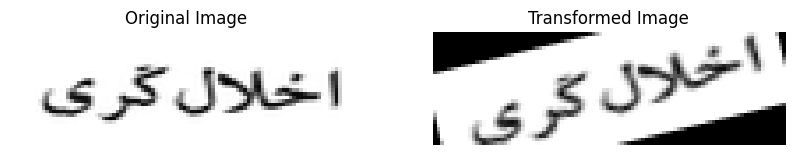

In [ ]:
# Load grayscale image
image_path = 'Data/persian_unique_ocr_dataset/generated_data/g_14.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Convert to NumPy array
image_np = np.array(image)
print(image_np.shape)
image_np = np.expand_dims(image_np, axis=2)
print(image_np.shape)
# Apply transformations
transformed = transforms.Training_transforms(image=image_np)
transformed_image = transformed['image']
print(transformed_image)
# Visualize the results
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_np, cmap='gray')
plt.axis('off')

# Transformed image
plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(transformed_image.permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray')  # Squeeze for grayscale
plt.axis('off')

plt.show()


In [11]:
def find_longest_string(string_list):
  longest_string = ""
  for string in string_list:
    if len(string) > len(longest_string):
      longest_string = string
  return longest_string

In [12]:
def unique_chars_in_strings(string_list):
  """
  Finds the unique characters across a list of strings.

  Args:
    string_list: A list of strings.

  Returns:
    A set containing the unique characters found in the input strings.
  """
  unique_chars = set()
  for string in string_list:
    unique_chars.update(string)
  return unique_chars


In [13]:
remove_chars = [" " , "‌"]
def remove_specific_first_char(s):
    res = str(s)
    if s and res[0] in remove_chars:  # Check if the first character is in the set
        res = res[1:]
    if len(res) > 0 :
        if s and res[-1] in remove_chars:
            res = res[:-1]   # Remove the first character
    return res  # Return the string as is if the first character is not in the set

# Apply the function to the column
df['label'] = df['label'].apply(remove_specific_first_char)
df

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
...,...,...
99262,همیشه,The_Schopenhauer_cure_data_annotated/page_0017...
99263,که از,The_Schopenhauer_cure_data_annotated/page_0192...
99264,سلب,The_Schopenhauer_cure_data_annotated/page_0019...
99265,همان‌گونه,The_Schopenhauer_cure_data_annotated/page_0023...


In [14]:
tdf['label'] = tdf['label'].apply(remove_specific_first_char)
tdf

,label,path
0,اغماض،,04964_166_518242.png
1,مرجعیت,05210_164_648841.png
2,تأثر،,04692_131_543131.png
3,همکاریشیما,05069_183_579292.png
4,داستان‌نویس،,05066_145_652706.png
...,...,...
6802,در,The_Schopenhauer_cure_data_annotated/page_0008...
6803,ایا,The_Schopenhauer_cure_data_annotated/page_0020...
6804,فراز,The_Schopenhauer_cure_data_annotated/page_0017...
6805,کامل,The_Schopenhauer_cure_data_annotated/page_0020...


In [ ]:
# Assuming 'df' is your DataFrame and 'label' is the column containing the strings
rows_with_specific_char = df[df['label'].str.contains(' ', na=False)]
# pd.set_option('display.max_rows', df.shape[0]+1)
rows_with_specific_char

,label,path
81315,تعلیق زدن,generated_data/g_28224.png
92540,انها را هرگز,The_Schopenhauer_cure_data_annotated/page_0023...
92546,که او,The_Schopenhauer_cure_data_annotated/page_0021...
92580,را نیز,The_Schopenhauer_cure_data_annotated/page_0016...
92589,او بر,The_Schopenhauer_cure_data_annotated/page_0024...
...,...,...
99177,کرد و فورا,The_Schopenhauer_cure_data_annotated/page_0016...
99193,باب ادامه,The_Schopenhauer_cure_data_annotated/page_0013...
99243,به‌خوبی درک,The_Schopenhauer_cure_data_annotated/page_0022...
99244,قرار گرفته,The_Schopenhauer_cure_data_annotated/page_0010...


In [16]:
index_names = df[df['label'].str.contains(' ', na=False)].index
index_names

Index([81315, 92540, 92546, 92580, 92589, 92601, 92605, 92646, 92657, 92658,
       ...
       99047, 99055, 99134, 99141, 99174, 99177, 99193, 99243, 99244, 99263],
      dtype='int64', length=388)

In [12]:
df = df.drop(index_names)
df

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
...,...,...
92502,اتوهایمان,generated_data/g_39993.png
92503,اسایه‌ای,generated_data/g_39995.png
92504,افضل,generated_data/g_39996.png
92505,اتمهایم,generated_data/g_39997.png


In [17]:

df['label'] = df['label'].str.replace(r'[آأً]', 'ا', regex=True)  # Replace 'آ' and 'أ' with 'ا'
df['label'] = df['label'].str.replace(r'ؤ', 'و', regex=True)     # Remove 'ً'
df['label'] = df['label'].str.replace(r'ۀ', 'ه', regex=True)
df['label'] = df['label'].str.replace(r'ي', 'ی', regex=True)
df['label'] = df['label'].str.replace(r'\u200d', '\u200c', regex=True)

df

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
...,...,...
99262,همیشه,The_Schopenhauer_cure_data_annotated/page_0017...
99263,که از,The_Schopenhauer_cure_data_annotated/page_0192...
99264,سلب,The_Schopenhauer_cure_data_annotated/page_0019...
99265,همان‌گونه,The_Schopenhauer_cure_data_annotated/page_0023...


In [18]:
eng_to_farsi = str.maketrans( '۰۱۲۳۴۵۶۷۸۹','0123456789')

# Replace English numbers with Farsi numbers
df['label'] = df['label'].apply(lambda x: x.translate(eng_to_farsi))
tdf['label'] = tdf['label'].apply(lambda x: x.translate(eng_to_farsi))

In [19]:
df[df['label'].str.contains('\u200d', na=False)]

,label,path


In [20]:
unique_characters = unique_chars_in_strings(df['label'].tolist())
print(unique_characters)
print(len(unique_characters))

{'»', 'ع', '4', '.', '؛', 'ض', ':', ')', '/', 'ه', '،', 'و', 'ا', 'ق', 'ح', '5', '%', 'د', 'ف', 'ص', '+', '(', '8', '6', 'خ', 'ش', 'ئ', 'ث', 'ی', 'ء', '7', 'ط', 'چ', '*', '”', ' ', 'ک', 'پ', 'ذ', 'غ', 'ل', '1', 'ب', 'س', 'ت', 'ژ', 'ر', '؟', 'م', '“', '«', '0', 'ظ', 'گ', '!', 'ز', 'ن', '2', 'ج', '3', '9', '\u200c'}
62


In [21]:
tdf['label'] = tdf['label'].str.replace(r'[آأً]', 'ا', regex=True)  # Replace 'آ' and 'أ' with 'ا'
tdf['label'] = tdf['label'].str.replace(r'ؤ', 'و', regex=True)     # Remove 'ً'
tdf['label'] = tdf['label'].str.replace(r'ۀ', 'ه', regex=True)
tdf['label'] = tdf['label'].str.replace(r'ي', 'ی', regex=True)
tdf['label'] = tdf['label'].str.replace(r'\u200d', '\u200c', regex=True)
unique_characters = unique_chars_in_strings(tdf['label'].tolist())
print(unique_characters)
print(len(unique_characters))
tdf

{'»', 'ع', '4', '.', '؛', 'ض', ':', ')', '/', 'ه', '،', 'و', 'ا', 'ق', '3', 'ح', '5', 'د', 'ف', 'ص', '+', '(', '8', '6', 'خ', 'ث', 'ش', 'ئ', 'ی', '7', 'ط', 'چ', '*', ' ', 'ک', 'ذ', 'غ', 'ل', '1', 'ب', 'س', 'ت', 'ژ', 'ر', '؟', 'م', '“', '«', '0', 'ظ', 'گ', '!', 'ز', 'ن', 'ج', '2', 'پ', '9', '\u200c'}
59


,label,path
0,اغماض،,04964_166_518242.png
1,مرجعیت,05210_164_648841.png
2,تاثر،,04692_131_543131.png
3,همکاریشیما,05069_183_579292.png
4,داستان‌نویس،,05066_145_652706.png
...,...,...
6802,در,The_Schopenhauer_cure_data_annotated/page_0008...
6803,ایا,The_Schopenhauer_cure_data_annotated/page_0020...
6804,فراز,The_Schopenhauer_cure_data_annotated/page_0017...
6805,کامل,The_Schopenhauer_cure_data_annotated/page_0020...


In [22]:

df = df.drop(df[df['label']== ""].index)
df[df['label']== ""]

,label,path


In [23]:
t = find_longest_string(df['label'].tolist())
print(t,len(t))

نیمه‌یارانه‌ای 14


In [24]:
dataset = df.set_index('path')['label'].to_dict()
print(len(dataset))
dict(list(dataset.items())[0:10])


99266


{'04468_153_86244.png': 'درکنار',
 '04335_0_275410.png': '4335',
 '05065_71_1234560.png': 'وتولد',
 '00459_42_782347.png': 'تراژدی\u200cای',
 '02664_92_166182.png': 'افزود:استفاده',
 '02250_87_77933.png': 'ریزگردها',
 '06715_66_498681.png': 'سالگذشته',
 '05562_35_186468.png': 'هولناک',
 '06711_29_9457.png': 'اباالحسن',
 '02937_30_899678.png': 'مواردرا'}

1.3 Custom Torch dataclass

In [25]:
tdataset = tdf.set_index('path')['label'].to_dict()
print(len(tdataset))
dict(list(tdataset.items())[0:10])


6807


{'04964_166_518242.png': 'اغماض،',
 '05210_164_648841.png': 'مرجعیت',
 '04692_131_543131.png': 'تاثر،',
 '05069_183_579292.png': 'همکاریشیما',
 '05066_145_652706.png': 'داستان\u200cنویس،',
 '04284_139_1015608.png': 'وفقط',
 '04558_156_35334.png': 'صحرایی',
 '03445_105_141224.png': 'دریافت.',
 '03051_25_39708.png': 'قطار',
 '04444_74_37847.png': 'افشای'}

1.4 Apply Data Augmentation and Preprocessing

1.5 Split data to Train, test and validation with proportion of 80%, 10% and 10% respectively.

In [26]:
img_dir = "Data/persian_unique_ocr_dataset"

In [27]:
import importlib
importlib.reload(data_loader)

train_dataset = data_loader.OCRDataset(img_dir,dataset , char_to_index , input_length=24,transform=transforms.Training_transforms)
val_dataset = data_loader.OCRDataset(img_dir,tdataset , char_to_index , input_length=24,transform=transforms.Testing_transforms)

Preloading Images: 100%|██████████| 6807/6807 [00:02<00:00, 2632.11it/s]


In [38]:
def collate_fn(batch):
    """Custom collate function to handle variable-length sequences.

    Args:
        batch: A list of data samples, where each sample is a tuple
                of (image, label, length).

    Returns:
        A tuple containing:
            images: A batched tensor of images.
            labels: A padded tensor of labels.
            target_lengths: A tensor of label lengths.
    """
    images, labels, input_lengths, tagret_lengths = zip(*batch)

    # Pad the labels to the maximum length in the batch
    labels = pad_sequence([label.clone().detach() for label in labels], 
                    batch_first=True, padding_value=0)
    # Stack the images and lengths
    # images = images.tensor(images)
    images = torch.stack(images, 0)
    input_lengths = torch.tensor(input_lengths)
    tagret_lengths = torch.tensor(tagret_lengths)

    return images, labels, input_lengths, tagret_lengths

In [39]:
train_data = DataLoader(train_dataset, batch_size=1000, shuffle=True,  collate_fn=collate_fn , num_workers= 4)
val_data = DataLoader(val_dataset, batch_size=1000, shuffle=True,  collate_fn=collate_fn, num_workers= 4)

In [40]:
num_classes = 63  # Adjust for Persian characters + numbers + punctuation + blank token
model = CRNN(num_classes=num_classes)
# Define CTC Loss and Optimizer
criterion = nn.CTCLoss(blank=0)  # 0 as the blank token index
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch:  [1/150]
Train_Loss: 3.828598053455353, Train_character_accuracy: 0.0003311527540789306, Train_word_accuracy: 0.0, Train_CER: 1.0009526017650652
Val_Loss: 3.7901991435459683, Val_character_accuracy: 0.0, Val_word_accuracy: 0.0, Val_CER: 1.0
Improved Train_Loss: 3.828598053455353 -> 3.828598053455353
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.7901991435459683 -> 3.7901991435459683
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 1.0009526017650652 -> 1.0009526017650652
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 1.0 -> 1.0
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.0

Epoch:  [2/150]
Train_Loss: 3.4937810850143434, Train_character_accuracy: 0.0, Train_word_accuracy: 0.0, Train_CER: 1.0
Val_Loss: 3.8022092410496304, Val_character_accuracy: 0.0, Val_word_accuracy: 0.0, Val_CER: 1.0
Improved Train_Loss: 3.828598053455353 -> 3.4937810850143434
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 1.0009526017650652 -> 1.0
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.


Epoch:  [3/150]
Train_Loss: 3.468709292411804, Train_character_accuracy: 0.0, Train_word_accuracy: 0.0, Train_CER: 1.0
Val_Loss: 3.78167462348938, Val_character_accuracy: 0.0, Val_word_accuracy: 0.0, Val_CER: 1.0
Improved Train_Loss: 3.4937810850143434 -> 3.468709292411804
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.7901991435459683 -> 3.78167462348938
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.


Epoch:  [4/150]
Train_Loss: 3.461214520931244, Train_character_accuracy: 0.0024295706708589216, Train_word_accuracy: 0.0, Train_CER: 0.995577056546321
Val_Loss: 3.7724818161555698, Val_character_accuracy: 0.0, Val_word_accuracy: 0.0, Val_CER: 1.0
Improved Train_Loss: 3.468709292411804 -> 3.461214520931244
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.78167462348938 -> 3.7724818161555698
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 1.0 -> 0.995577056546321
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.0003311527540789306 -> 0.0024295706708589216
Model checkpoint saved for metric 'Tr

Epoch:  [5/150]
Train_Loss: 3.4236930227279663, Train_character_accuracy: 0.016493168313218176, Train_word_accuracy: 1.0073942739709467e-05, Train_CER: 0.9735075549437968
Val_Loss: 3.9432753154209683, Val_character_accuracy: 0.018638308353753016, Val_word_accuracy: 0.0, Val_CER: 0.9090283853064821
Improved Train_Loss: 3.461214520931244 -> 3.4236930227279663
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.995577056546321 -> 0.9735075549437968
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 1.0 -> 0.9090283853064821
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_accuracy: 0.0024295706708589216 -> 0.016493

Epoch:  [6/150]
Train_Loss: 3.1590034580230713, Train_character_accuracy: 0.05137448542437076, Train_word_accuracy: 0.0, Train_CER: 0.9128791389124736
Val_Loss: 3.318554469517299, Val_character_accuracy: 0.02025956920257051, Val_word_accuracy: 0.0, Val_CER: 0.9039604230547386
Improved Train_Loss: 3.4236930227279663 -> 3.1590034580230713
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.7724818161555698 -> 3.318554469517299
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.9735075549437968 -> 0.9128791389124736
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.9090283853064821 -> 0.9039604230547386
Model check

Epoch:  [7/150]
Train_Loss: 3.0432980489730834, Train_character_accuracy: 0.05374270308159085, Train_word_accuracy: 0.0, Train_CER: 0.9036836779173031
Val_Loss: 3.202697277069092, Val_character_accuracy: 0.021362778437403064, Val_word_accuracy: 0.0, Val_CER: 0.9058811126682443
Improved Train_Loss: 3.1590034580230713 -> 3.0432980489730834
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.318554469517299 -> 3.202697277069092
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.9128791389124736 -> 0.9036836779173031
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.05137448542437076 -> 0.0537427030

Epoch:  [8/150]
Train_Loss: 2.9307573103904723, Train_character_accuracy: 0.06421503555539713, Train_word_accuracy: 1.0073942739709467e-05, Train_CER: 0.8745990883049394
Val_Loss: 3.0835666997092113, Val_character_accuracy: 0.047492353795047244, Val_word_accuracy: 0.0, Val_CER: 0.8496238169221862
Improved Train_Loss: 3.0432980489730834 -> 2.9307573103904723
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.202697277069092 -> 3.0835666997092113
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.9036836779173031 -> 0.8745990883049394
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.9039604230547386 -> 0.8496238

Epoch:  [9/150]
Train_Loss: 2.823340320587158, Train_character_accuracy: 0.09279793009373669, Train_word_accuracy: 8.059154191767573e-05, Train_CER: 0.8079586547599263
Val_Loss: 3.0191783564431325, Val_character_accuracy: 0.07896871409842786, Val_word_accuracy: 0.00029381519024533566, Val_CER: 0.8122099579900373
Improved Train_Loss: 2.9307573103904723 -> 2.823340320587158
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.0835666997092113 -> 3.0191783564431325
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.8745990883049394 -> 0.8079586547599263
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.8496238169221

Epoch:  [10/150]
Train_Loss: 2.697562909126282, Train_character_accuracy: 0.12555550593391507, Train_word_accuracy: 0.0006044365643825681, Train_CER: 0.758087284047079
Val_Loss: 2.7766384397234236, Val_character_accuracy: 0.1149048713178438, Val_word_accuracy: 0.004554135448802703, Val_CER: 0.7696069596466247
Improved Train_Loss: 2.823340320587158 -> 2.697562909126282
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.0191783564431325 -> 2.7766384397234236
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.8079586547599263 -> 0.758087284047079
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.8122099579900373 -

Epoch:  [11/150]
Train_Loss: 2.52207328081131, Train_character_accuracy: 0.14675018507629145, Train_word_accuracy: 0.0036971369854733745, Train_CER: 0.7136318329899213
Val_Loss: 2.4264752183641707, Val_character_accuracy: 0.15469090722533452, Val_word_accuracy: 0.04186866460996033, Val_CER: 0.663777854941363
Improved Train_Loss: 2.697562909126282 -> 2.52207328081131
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.7766384397234236 -> 2.4264752183641707
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.758087284047079 -> 0.7136318329899213
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.7696069596466247 -> 

Epoch:  [12/150]
Train_Loss: 2.2584195518493653, Train_character_accuracy: 0.18290006126479638, Train_word_accuracy: 0.04422460862732456, Train_CER: 0.6206866287606423
Val_Loss: 2.100548710141863, Val_character_accuracy: 0.19201536354040066, Val_word_accuracy: 0.11708535331276627, Val_CER: 0.5849380692924105
Improved Train_Loss: 2.52207328081131 -> 2.2584195518493653
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.4264752183641707 -> 2.100548710141863
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.7136318329899213 -> 0.6206866287606423
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.663777854941363 -> 

Epoch:  [13/150]
Train_Loss: 2.0128640222549437, Train_character_accuracy: 0.2066202355368072, Train_word_accuracy: 0.06166260350976165, Train_CER: 0.5570771730290103
Val_Loss: 1.8512417418616158, Val_character_accuracy: 0.22707975065386726, Val_word_accuracy: 0.12031732040546496, Val_CER: 0.5110829668674538
Improved Train_Loss: 2.2584195518493653 -> 2.0128640222549437
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.100548710141863 -> 1.8512417418616158
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.6206866287606423 -> 0.5570771730290103
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.5849380692924105 

Epoch:  [14/150]
Train_Loss: 1.7247269976139068, Train_character_accuracy: 0.23596885992499053, Train_word_accuracy: 0.07370096508371446, Train_CER: 0.4844345355660914
Val_Loss: 1.5264008385794503, Val_character_accuracy: 0.2917270407616163, Val_word_accuracy: 0.15146173057147055, Val_CER: 0.43005991649667275
Improved Train_Loss: 2.0128640222549437 -> 1.7247269976139068
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 1.8512417418616158 -> 1.5264008385794503
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.5570771730290103 -> 0.4844345355660914
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.511082966867453

Epoch:  [15/150]
Train_Loss: 1.4512875151634217, Train_character_accuracy: 0.2776450292070727, Train_word_accuracy: 0.09425180827272178, Train_CER: 0.4127079019857007
Val_Loss: 1.2526368413652693, Val_character_accuracy: 0.3480638386257796, Val_word_accuracy: 0.19230204201557222, Val_CER: 0.36003939827209924
Improved Train_Loss: 1.7247269976139068 -> 1.4512875151634217
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 1.5264008385794503 -> 1.2526368413652693
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.4844345355660914 -> 0.4127079019857007
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.4300599164966727

Epoch:  [16/150]
Train_Loss: 1.219598308801651, Train_character_accuracy: 0.3245096097220299, Train_word_accuracy: 0.12701227006225696, Train_CER: 0.3508894643157632
Val_Loss: 0.9820176618439811, Val_character_accuracy: 0.40859504611361175, Val_word_accuracy: 0.25209343323049804, Val_CER: 0.2857386887796757
Improved Train_Loss: 1.4512875151634217 -> 1.219598308801651
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 1.2526368413652693 -> 0.9820176618439811
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.4127079019857007 -> 0.3508894643157632
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.36003939827209924 

Epoch:  [17/150]
Train_Loss: 0.994427255988121, Train_character_accuracy: 0.3831962962980978, Train_word_accuracy: 0.17957810327806098, Train_CER: 0.2887257053016225
Val_Loss: 0.780506798199245, Val_character_accuracy: 0.4933822521949598, Val_word_accuracy: 0.34361686499192007, Val_CER: 0.2226361407718832
Improved Train_Loss: 1.219598308801651 -> 0.994427255988121
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.9820176618439811 -> 0.780506798199245
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.3508894643157632 -> 0.2887257053016225
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.2857386887796757 -> 0.

Epoch:  [18/150]
Train_Loss: 0.8129029130935669, Train_character_accuracy: 0.4455969118990117, Train_word_accuracy: 0.2464388612415127, Train_CER: 0.23737812318418977
Val_Loss: 0.652211172240121, Val_character_accuracy: 0.5670783183455759, Val_word_accuracy: 0.42089026002644336, Val_CER: 0.18392270609106215
Improved Train_Loss: 0.994427255988121 -> 0.8129029130935669
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.780506798199245 -> 0.652211172240121
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.2887257053016225 -> 0.23737812318418977
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.2226361407718832 ->

Epoch:  [19/150]
Train_Loss: 0.6799098742008209, Train_character_accuracy: 0.5020963015526652, Train_word_accuracy: 0.31246348195756857, Train_CER: 0.19843003453428984
Val_Loss: 0.5111208430358342, Val_character_accuracy: 0.616858260447669, Val_word_accuracy: 0.4991920082268253, Val_CER: 0.14499265201116252
Improved Train_Loss: 0.8129029130935669 -> 0.6799098742008209
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.652211172240121 -> 0.5111208430358342
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.23737812318418977 -> 0.19843003453428984
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.1839227060910621

Epoch:  [20/150]
Train_Loss: 0.5668531945347786, Train_character_accuracy: 0.5573909075249414, Train_word_accuracy: 0.3790119476960893, Train_CER: 0.16502006238723751
Val_Loss: 0.46328618696757723, Val_character_accuracy: 0.6802913681728177, Val_word_accuracy: 0.5720581754076686, Val_CER: 0.12027822209620373
Improved Train_Loss: 0.6799098742008209 -> 0.5668531945347786
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.5111208430358342 -> 0.46328618696757723
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.19843003453428984 -> 0.16502006238723751
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.1449926520111

Epoch:  [21/150]
Train_Loss: 0.49069575130939486, Train_character_accuracy: 0.5997742739978025, Train_word_accuracy: 0.4341164144823001, Train_CER: 0.141550950174749
Val_Loss: 0.3748674009527479, Val_character_accuracy: 0.6866164382824289, Val_word_accuracy: 0.6009989716468341, Val_CER: 0.10699517823801663
Improved Train_Loss: 0.5668531945347786 -> 0.49069575130939486
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.46328618696757723 -> 0.3748674009527479
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.16502006238723751 -> 0.141550950174749
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.1202782220962037

Epoch:  [22/150]
Train_Loss: 0.4183949679136276, Train_character_accuracy: 0.641250447557606, Train_word_accuracy: 0.48951302560796245, Train_CER: 0.12008128493758038
Val_Loss: 0.33331215381622314, Val_character_accuracy: 0.7264809142606294, Val_word_accuracy: 0.6424269134714264, Val_CER: 0.09048662639451543
Improved Train_Loss: 0.49069575130939486 -> 0.4183949679136276
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.3748674009527479 -> 0.33331215381622314
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.141550950174749 -> 0.12008128493758038
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.10699517823801

Epoch:  [23/150]
Train_Loss: 0.37418041527271273, Train_character_accuracy: 0.6711768815806676, Train_word_accuracy: 0.5300807930207725, Train_CER: 0.10675706267978562
Val_Loss: 0.27948901057243347, Val_character_accuracy: 0.7531451072531028, Val_word_accuracy: 0.6793007198472161, Val_CER: 0.07977244259747573
Improved Train_Loss: 0.4183949679136276 -> 0.37418041527271273
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.33331215381622314 -> 0.27948901057243347
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.12008128493758038 -> 0.10675706267978562
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0904866263

Epoch:  [24/150]
Train_Loss: 0.3279563421010971, Train_character_accuracy: 0.7014802866857387, Train_word_accuracy: 0.57038663792235, Train_CER: 0.09317070514358629
Val_Loss: 0.24921763581889017, Val_character_accuracy: 0.7878269731541281, Val_word_accuracy: 0.713824004701043, Val_CER: 0.06766879570978303
Improved Train_Loss: 0.37418041527271273 -> 0.3279563421010971
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.27948901057243347 -> 0.24921763581889017
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.10675706267978562 -> 0.09317070514358629
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.07977244259747

Epoch:  [25/150]
Train_Loss: 0.2952823132276535, Train_character_accuracy: 0.7268397686298449, Train_word_accuracy: 0.6038422017609252, Train_CER: 0.08367097160490687
Val_Loss: 0.22484609271798814, Val_character_accuracy: 0.7964714618579358, Val_word_accuracy: 0.7339503452328485, Val_CER: 0.06239319174532931
Improved Train_Loss: 0.3279563421010971 -> 0.2952823132276535
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.24921763581889017 -> 0.22484609271798814
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.09317070514358629 -> 0.08367097160490687
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.067668795709

Epoch:  [26/150]
Train_Loss: 0.2675767512619495, Train_character_accuracy: 0.7452884187505542, Train_word_accuracy: 0.6305180021356759, Train_CER: 0.07534416413791034
Val_Loss: 0.2053637057542801, Val_character_accuracy: 0.8147960324309577, Val_word_accuracy: 0.7521668870280593, Val_CER: 0.05691880267684595
Improved Train_Loss: 0.2952823132276535 -> 0.2675767512619495
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.22484609271798814 -> 0.2053637057542801
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.08367097160490687 -> 0.07534416413791034
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.06239319174532

Epoch:  [27/150]
Train_Loss: 0.24259548962116242, Train_character_accuracy: 0.7640000938721326, Train_word_accuracy: 0.6569419539419338, Train_CER: 0.06850071678411708
Val_Loss: 0.1816116443702153, Val_character_accuracy: 0.8211922668976975, Val_word_accuracy: 0.7706772440135155, Val_CER: 0.05194552806937121
Improved Train_Loss: 0.2675767512619495 -> 0.24259548962116242
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.2053637057542801 -> 0.1816116443702153
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.07534416413791034 -> 0.06850071678411708
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0569188026768

Epoch:  [28/150]
Train_Loss: 0.22529864236712455, Train_character_accuracy: 0.7794369178651595, Train_word_accuracy: 0.6784699695766929, Train_CER: 0.06327954145912978
Val_Loss: 0.19298464272703444, Val_character_accuracy: 0.836662922022984, Val_word_accuracy: 0.7740561187013368, Val_CER: 0.050241311094109724
Improved Train_Loss: 0.24259548962116242 -> 0.22529864236712455
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.06850071678411708 -> 0.06327954145912978
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.05194552806937121 -> 0.050241311094109724
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_accurac

Epoch:  [29/150]
Train_Loss: 0.20950643643736838, Train_character_accuracy: 0.7910614564139034, Train_word_accuracy: 0.693621179457216, Train_CER: 0.058889162061698606
Val_Loss: 0.17120086082390376, Val_character_accuracy: 0.8355963150940997, Val_word_accuracy: 0.789922138974585, Val_CER: 0.047206975809884616
Improved Train_Loss: 0.22529864236712455 -> 0.20950643643736838
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1816116443702153 -> 0.17120086082390376
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.06327954145912978 -> 0.058889162061698606
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.050241311

Epoch:  [30/150]
Train_Loss: 0.19764990836381913, Train_character_accuracy: 0.7995386967658431, Train_word_accuracy: 0.7059919811415792, Train_CER: 0.05597546497451815
Val_Loss: 0.1557128897735051, Val_character_accuracy: 0.8503996978322669, Val_word_accuracy: 0.8050536212722198, Val_CER: 0.0430633536517186
Improved Train_Loss: 0.20950643643736838 -> 0.19764990836381913
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.17120086082390376 -> 0.1557128897735051
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.058889162061698606 -> 0.05597546497451815
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.04720697580

Epoch:  [31/150]
Train_Loss: 0.1824133141338825, Train_character_accuracy: 0.8142032258684019, Train_word_accuracy: 0.7247295146374388, Train_CER: 0.05134029318543663
Val_Loss: 0.1399491195167814, Val_character_accuracy: 0.8592860045347508, Val_word_accuracy: 0.8226825326869399, Val_CER: 0.038584069082085844
Improved Train_Loss: 0.19764990836381913 -> 0.1824133141338825
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1557128897735051 -> 0.1399491195167814
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.05597546497451815 -> 0.05134029318543663
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0430633536517

Epoch:  [32/150]
Train_Loss: 0.17023320525884628, Train_character_accuracy: 0.8251922065245771, Train_word_accuracy: 0.7410493018757681, Train_CER: 0.047736898016701855
Val_Loss: 0.1394071706703731, Val_character_accuracy: 0.8675265800628, Val_word_accuracy: 0.828852651682092, Val_CER: 0.036310275754965045
Improved Train_Loss: 0.1824133141338825 -> 0.17023320525884628
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1399491195167814 -> 0.1394071706703731
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.05134029318543663 -> 0.047736898016701855
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.03858406908208

Epoch:  [33/150]
Train_Loss: 0.16402129366993903, Train_character_accuracy: 0.8287272346692006, Train_word_accuracy: 0.7471238893478129, Train_CER: 0.04635861419175957
Val_Loss: 0.1251702755689621, Val_character_accuracy: 0.8758997493647439, Val_word_accuracy: 0.839429998530924, Val_CER: 0.03382486961155977
Improved Train_Loss: 0.17023320525884628 -> 0.16402129366993903
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1394071706703731 -> 0.1251702755689621
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.047736898016701855 -> 0.04635861419175957
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.036310275754

Epoch:  [34/150]
Train_Loss: 0.15274394616484643, Train_character_accuracy: 0.8385874576424436, Train_word_accuracy: 0.7612576310116254, Train_CER: 0.042851179785276104
Val_Loss: 0.11856654499258314, Val_character_accuracy: 0.8841267149441377, Val_word_accuracy: 0.8479506390480388, Val_CER: 0.031956424816715685
Improved Train_Loss: 0.16402129366993903 -> 0.15274394616484643
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1251702755689621 -> 0.11856654499258314
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.04635861419175957 -> 0.042851179785276104
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0338248

Epoch:  [35/150]
Train_Loss: 0.14521615147590639, Train_character_accuracy: 0.8449590309854176, Train_word_accuracy: 0.7703846231338021, Train_CER: 0.041002548281475655
Val_Loss: 0.125482371875218, Val_character_accuracy: 0.8855563683180679, Val_word_accuracy: 0.8400176289114147, Val_CER: 0.034303540671984926
Improved Train_Loss: 0.15274394616484643 -> 0.14521615147590639
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.042851179785276104 -> 0.041002548281475655
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.8385874576424436 -> 0.8449590309854176
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_

Epoch:  [36/150]
Train_Loss: 0.15034566156566143, Train_character_accuracy: 0.843506606694519, Train_word_accuracy: 0.7656297221606593, Train_CER: 0.04231102177428213
Val_Loss: 0.12273701493229185, Val_character_accuracy: 0.8788940169157743, Val_word_accuracy: 0.8354634934626121, Val_CER: 0.034086386411199106


Epoch:  [37/150]
Train_Loss: 0.1352472310513258, Train_character_accuracy: 0.8535374123478249, Train_word_accuracy: 0.7813752946628252, Train_CER: 0.03852833728974606
Val_Loss: 0.1066336642418589, Val_character_accuracy: 0.894484115635273, Val_word_accuracy: 0.8601439694432202, Val_CER: 0.02865386127836546
Improved Train_Loss: 0.14521615147590639 -> 0.1352472310513258
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.11856654499258314 -> 0.1066336642418589
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.041002548281475655 -> 0.03852833728974606
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0319564248167

Epoch:  [38/150]
Train_Loss: 0.13098718255758285, Train_character_accuracy: 0.8583816718271843, Train_word_accuracy: 0.7876312131041847, Train_CER: 0.037388461471480866
Val_Loss: 0.11758479475975037, Val_character_accuracy: 0.8845206941431987, Val_word_accuracy: 0.8494197149992655, Val_CER: 0.032105326320839754
Improved Train_Loss: 0.1352472310513258 -> 0.13098718255758285
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.03852833728974606 -> 0.037388461471480866
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.8535374123478249 -> 0.8583816718271843
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_

Epoch:  [39/150]
Train_Loss: 0.12121112316846848, Train_character_accuracy: 0.8657322416288821, Train_word_accuracy: 0.7982894445227974, Train_CER: 0.03475749821427093
Val_Loss: 0.1010845388684954, Val_character_accuracy: 0.9001958568925661, Val_word_accuracy: 0.8658733656530042, Val_CER: 0.026463549182808764
Improved Train_Loss: 0.13098718255758285 -> 0.12121112316846848
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1066336642418589 -> 0.1010845388684954
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.037388461471480866 -> 0.03475749821427093
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0286538612

Epoch:  [40/150]
Train_Loss: 0.11772514835000038, Train_character_accuracy: 0.8702736860204902, Train_word_accuracy: 0.8039912961134729, Train_CER: 0.033853408091314326
Val_Loss: 0.1025679622377668, Val_character_accuracy: 0.9008106121393938, Val_word_accuracy: 0.8670486264139856, Val_CER: 0.027587354372281644
Improved Train_Loss: 0.12121112316846848 -> 0.11772514835000038
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.03475749821427093 -> 0.033853408091314326
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.8657322416288821 -> 0.8702736860204902
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_

Epoch:  [41/150]
Train_Loss: 0.11245163261890412, Train_character_accuracy: 0.8755021168664505, Train_word_accuracy: 0.8131888058348277, Train_CER: 0.03204871646105301
Val_Loss: 0.09266092521803719, Val_character_accuracy: 0.9060290305270098, Val_word_accuracy: 0.8780666960481857, Val_CER: 0.025158487432616995
Improved Train_Loss: 0.11772514835000038 -> 0.11245163261890412
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1010845388684954 -> 0.09266092521803719
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.033853408091314326 -> 0.03204871646105301
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.02646354

Epoch:  [42/150]
Train_Loss: 0.10734760619699955, Train_character_accuracy: 0.8812913921793708, Train_word_accuracy: 0.8199383474704329, Train_CER: 0.030606953378345396
Val_Loss: 0.09067695587873459, Val_character_accuracy: 0.9109173203796547, Val_word_accuracy: 0.8789481416189217, Val_CER: 0.024231418810528538
Improved Train_Loss: 0.11245163261890412 -> 0.10734760619699955
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.09266092521803719 -> 0.09067695587873459
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.03204871646105301 -> 0.030606953378345396
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.025158

Epoch:  [43/150]
Train_Loss: 0.10092398352921009, Train_character_accuracy: 0.8849501594515249, Train_word_accuracy: 0.8263151532246691, Train_CER: 0.028838591568025602
Val_Loss: 0.09102505551917213, Val_character_accuracy: 0.9191848013703804, Val_word_accuracy: 0.8892316732775084, Val_CER: 0.022551588186228988
Improved Train_Loss: 0.10734760619699955 -> 0.10092398352921009
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.030606953378345396 -> 0.028838591568025602
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.024231418810528538 -> 0.022551588186228988
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_ac

Epoch:  [44/150]
Train_Loss: 0.104835986495018, Train_character_accuracy: 0.8827361661020295, Train_word_accuracy: 0.8215199564805674, Train_CER: 0.030327807209367858
Val_Loss: 0.089508375951222, Val_character_accuracy: 0.9153776582781464, Val_word_accuracy: 0.8843837226384604, Val_CER: 0.023841668508922793
Improved Val_Loss: 0.09067695587873459 -> 0.089508375951222
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.


Epoch:  [45/150]
Train_Loss: 0.09886720143258572, Train_character_accuracy: 0.888997017421187, Train_word_accuracy: 0.8312513851671267, Train_CER: 0.028664461248125328
Val_Loss: 0.09020327350922994, Val_character_accuracy: 0.9119389610414033, Val_word_accuracy: 0.8852651682091964, Val_CER: 0.022721426346371244
Improved Train_Loss: 0.10092398352921009 -> 0.09886720143258572
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.028838591568025602 -> 0.028664461248125328
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.8849501594515249 -> 0.888997017421187
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_

Epoch:  [46/150]
Train_Loss: 0.09483769066631793, Train_character_accuracy: 0.8910315775241516, Train_word_accuracy: 0.8359659903693107, Train_CER: 0.027388575629413374
Val_Loss: 0.08704546413251332, Val_character_accuracy: 0.9105997371997917, Val_word_accuracy: 0.8817393859262523, Val_CER: 0.023617624642305105
Improved Train_Loss: 0.09886720143258572 -> 0.09483769066631793
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.089508375951222 -> 0.08704546413251332
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.028664461248125328 -> 0.027388575629413374
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_ac

Epoch:  [47/150]
Train_Loss: 0.08997481890022754, Train_character_accuracy: 0.8957859639465552, Train_word_accuracy: 0.8429371587451897, Train_CER: 0.026055762505805827
Val_Loss: 0.08875695349914688, Val_character_accuracy: 0.9161535858010765, Val_word_accuracy: 0.8896723960628764, Val_CER: 0.022297913307168474
Improved Train_Loss: 0.09483769066631793 -> 0.08997481890022754
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.027388575629413374 -> 0.026055762505805827
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.022551588186228988 -> 0.022297913307168474
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_ac

Epoch:  [48/150]
Train_Loss: 0.08930130243301392, Train_character_accuracy: 0.8973347124293378, Train_word_accuracy: 0.8449217254649125, Train_CER: 0.02592078959238912
Val_Loss: 0.08302935851471764, Val_character_accuracy: 0.9254605370759366, Val_word_accuracy: 0.8971646834141325, Val_CER: 0.02074414004779804
Improved Train_Loss: 0.08997481890022754 -> 0.08930130243301392
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.08704546413251332 -> 0.08302935851471764
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.026055762505805827 -> 0.02592078959238912
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.02229791

Epoch:  [49/150]
Train_Loss: 0.09092702001333236, Train_character_accuracy: 0.8967865424930201, Train_word_accuracy: 0.8418592468720408, Train_CER: 0.026452729607636616
Val_Loss: 0.08044060958283288, Val_character_accuracy: 0.9223616283491884, Val_word_accuracy: 0.8973115910092552, Val_CER: 0.02000740229034631
Improved Val_Loss: 0.08302935851471764 -> 0.08044060958283288
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.02074414004779804 -> 0.02000740229034631
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_word_accuracy: 0.8971646834141325 -> 0.8973115910092552
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [50/150]
Train_Loss: 0.08469366252422333, Train_character_accuracy: 0.9019497419523219, Train_word_accuracy: 0.849998992605726, Train_CER: 0.024711765868858926
Val_Loss: 0.07845268824270793, Val_character_accuracy: 0.9248435469524761, Val_word_accuracy: 0.8973115910092552, Val_CER: 0.02040577682931142
Improved Train_Loss: 0.08930130243301392 -> 0.08469366252422333
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.08044060958283288 -> 0.07845268824270793
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.02592078959238912 -> 0.024711765868858926
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_acc

Epoch:  [51/150]
Train_Loss: 0.08285348892211913, Train_character_accuracy: 0.906332417035999, Train_word_accuracy: 0.8557612878528399, Train_CER: 0.023586534308231565
Val_Loss: 0.08289847097226552, Val_character_accuracy: 0.9235858866692377, Val_word_accuracy: 0.8915821947994711, Val_CER: 0.021374908737182858
Improved Train_Loss: 0.08469366252422333 -> 0.08285348892211913
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.024711765868858926 -> 0.023586534308231565
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9019497419523219 -> 0.906332417035999
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_

Epoch:  [52/150]
Train_Loss: 0.0791331396996975, Train_character_accuracy: 0.9076562054209273, Train_word_accuracy: 0.8584812523925615, Train_CER: 0.02302973307370583
Val_Loss: 0.08090401653732572, Val_character_accuracy: 0.925284110091594, Val_word_accuracy: 0.8992213897458499, Val_CER: 0.01974508645949808
Improved Train_Loss: 0.08285348892211913 -> 0.0791331396996975
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.023586534308231565 -> 0.02302973307370583
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.02000740229034631 -> 0.01974508645949808
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_accuracy: 

Epoch:  [53/150]
Train_Loss: 0.07903848201036454, Train_character_accuracy: 0.9066143540170717, Train_word_accuracy: 0.8583805129651643, Train_CER: 0.023112370658106354
Val_Loss: 0.07374677807092667, Val_character_accuracy: 0.931853262055058, Val_word_accuracy: 0.9056853239312472, Val_CER: 0.018338004730688726
Improved Train_Loss: 0.0791331396996975 -> 0.07903848201036454
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.07845268824270793 -> 0.07374677807092667
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.01974508645949808 -> 0.018338004730688726
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9

Epoch:  [54/150]
Train_Loss: 0.07501415964215993, Train_character_accuracy: 0.9126924889113708, Train_word_accuracy: 0.8651401285435094, Train_CER: 0.02182984539531594
Val_Loss: 0.07597365762506213, Val_character_accuracy: 0.9278300978449573, Val_word_accuracy: 0.9062729543117379, Val_CER: 0.01882826500499483
Improved Train_Loss: 0.07903848201036454 -> 0.07501415964215993
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.02302973307370583 -> 0.02182984539531594
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9076562054209273 -> 0.9126924889113708
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_lo

Epoch:  [55/150]
Train_Loss: 0.07513057049363851, Train_character_accuracy: 0.9117625766832306, Train_word_accuracy: 0.8653013116273447, Train_CER: 0.02189663821315141
Val_Loss: 0.0761822983622551, Val_character_accuracy: 0.9341678416308209, Val_word_accuracy: 0.9093580138093139, Val_CER: 0.0188246404200569
Improved Train_word_accuracy: 0.8651401285435094 -> 0.8653013116273447
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_word_accuracy.txt'.
Improved Val_character_accuracy: 0.931853262055058 -> 0.9341678416308209
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9062729543117379 -> 0.9093580138093139
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_V

Epoch:  [56/150]
Train_Loss: 0.07286631569266319, Train_character_accuracy: 0.9143299598618886, Train_word_accuracy: 0.8690185964982975, Train_CER: 0.021127877013326194
Val_Loss: 0.07619069942406245, Val_character_accuracy: 0.9366272047165497, Val_word_accuracy: 0.9078889378580872, Val_CER: 0.01868958620831692
Improved Train_Loss: 0.07501415964215993 -> 0.07286631569266319
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.02182984539531594 -> 0.021127877013326194
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9126924889113708 -> 0.9143299598618886
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_

Epoch:  [57/150]
Train_Loss: 0.07516960773617029, Train_character_accuracy: 0.9136611763893835, Train_word_accuracy: 0.8671851389196704, Train_CER: 0.02169241697932286
Val_Loss: 0.07777470030954906, Val_character_accuracy: 0.93090551499016, Val_word_accuracy: 0.9024533568385485, Val_CER: 0.019837915540868372


Epoch:  [58/150]
Train_Loss: 0.07441009864211083, Train_character_accuracy: 0.9138425176468187, Train_word_accuracy: 0.8663490016722745, Train_CER: 0.021797200073246228
Val_Loss: 0.073810661477702, Val_character_accuracy: 0.9327441952819808, Val_word_accuracy: 0.9033348024092845, Val_CER: 0.01886818232124534


Epoch:  [59/150]
Train_Loss: 0.07523648712784052, Train_character_accuracy: 0.9132148242984118, Train_word_accuracy: 0.8661978925311788, Train_CER: 0.02183808142217869
Val_Loss: 0.07358757566128458, Val_character_accuracy: 0.9331346776958764, Val_word_accuracy: 0.9084765682385779, Val_CER: 0.018325164380695445
Improved Val_Loss: 0.07374677807092667 -> 0.07358757566128458
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.018338004730688726 -> 0.018325164380695445
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.


Epoch:  [60/150]
Train_Loss: 0.07914680179208516, Train_character_accuracy: 0.9114860668687446, Train_word_accuracy: 0.8608788507646122, Train_CER: 0.02294217769103428
Val_Loss: 0.0725614417876516, Val_character_accuracy: 0.9350941913296112, Val_word_accuracy: 0.91464668723373, Val_CER: 0.017001143576727527
Improved Val_Loss: 0.07358757566128458 -> 0.0725614417876516
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.018325164380695445 -> 0.017001143576727527
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_word_accuracy: 0.9093580138093139 -> 0.91464668723373
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [61/150]
Train_Loss: 0.07056532111018896, Train_character_accuracy: 0.9187425457199311, Train_word_accuracy: 0.8733503918763725, Train_CER: 0.020449749736716063
Val_Loss: 0.0706904147352491, Val_character_accuracy: 0.9354672403762502, Val_word_accuracy: 0.9125899809020126, Val_CER: 0.017736144664306844
Improved Train_Loss: 0.07286631569266319 -> 0.07056532111018896
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.0725614417876516 -> 0.0706904147352491
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.021127877013326194 -> 0.020449749736716063
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_acc

Epoch:  [62/150]
Train_Loss: 0.06956899035722017, Train_character_accuracy: 0.9207249473973808, Train_word_accuracy: 0.8765639796103399, Train_CER: 0.020077657915638685
Val_Loss: 0.07586942080940519, Val_character_accuracy: 0.931563495324294, Val_word_accuracy: 0.9021595416483033, Val_CER: 0.01895093015630696
Improved Train_Loss: 0.07056532111018896 -> 0.06956899035722017
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.020449749736716063 -> 0.020077657915638685
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9187425457199311 -> 0.9207249473973808
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_

Epoch:  [63/150]
Train_Loss: 0.0676442800462246, Train_character_accuracy: 0.9206618201161855, Train_word_accuracy: 0.8783772893034876, Train_CER: 0.019653390753263812
Val_Loss: 0.06689927407673427, Val_character_accuracy: 0.9414671621739671, Val_word_accuracy: 0.9156750403995887, Val_CER: 0.01651306963118333
Improved Train_Loss: 0.06956899035722017 -> 0.0676442800462246
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.0706904147352491 -> 0.06689927407673427
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.020077657915638685 -> 0.019653390753263812
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.017001143

Epoch:  [64/150]
Train_Loss: 0.062374612614512444, Train_character_accuracy: 0.9255021621654884, Train_word_accuracy: 0.8845526162029295, Train_CER: 0.018312396590709396
Val_Loss: 0.07208578448210444, Val_character_accuracy: 0.9422479480136591, Val_word_accuracy: 0.9140590568532393, Val_CER: 0.01774650394086268
Improved Train_Loss: 0.0676442800462246 -> 0.062374612614512444
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.019653390753263812 -> 0.018312396590709396
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9207249473973808 -> 0.9255021621654884
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metric

Epoch:  [65/150]
Train_Loss: 0.07703859984874725, Train_character_accuracy: 0.9156300558398771, Train_word_accuracy: 0.866711663610904, Train_CER: 0.022256301479298263
Val_Loss: 0.06737924580063138, Val_character_accuracy: 0.9403763209109882, Val_word_accuracy: 0.916409578375202, Val_CER: 0.015692058949000325
Improved Val_CER: 0.01651306963118333 -> 0.015692058949000325
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_word_accuracy: 0.9156750403995887 -> 0.916409578375202
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [66/150]
Train_Loss: 0.06447562135756016, Train_character_accuracy: 0.9235517642387973, Train_word_accuracy: 0.8825982713114259, Train_CER: 0.018907916810018226
Val_Loss: 0.0640743225812912, Val_character_accuracy: 0.9425734683261597, Val_word_accuracy: 0.9212575290142501, Val_CER: 0.01546245488510803
Improved Val_Loss: 0.06689927407673427 -> 0.0640743225812912
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.015692058949000325 -> 0.01546245488510803
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9422479480136591 -> 0.9425734683261597
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accura

Epoch:  [67/150]
Train_Loss: 0.06473594419658184, Train_character_accuracy: 0.9246601115737891, Train_word_accuracy: 0.8817722080067697, Train_CER: 0.01904226567907989
Val_Loss: 0.06449448423726219, Val_character_accuracy: 0.9440280369816084, Val_word_accuracy: 0.9175848391361834, Val_CER: 0.016376924089572826
Improved Val_character_accuracy: 0.9425734683261597 -> 0.9440280369816084
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [68/150]
Train_Loss: 0.060960581451654436, Train_character_accuracy: 0.9283480460384759, Train_word_accuracy: 0.8890153728366208, Train_CER: 0.01783365504982171
Val_Loss: 0.0662944455231939, Val_character_accuracy: 0.945358356167104, Val_word_accuracy: 0.9203760834435141, Val_CER: 0.016072043132422154
Improved Train_Loss: 0.062374612614512444 -> 0.060960581451654436
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.018312396590709396 -> 0.01783365504982171
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9255021621654884 -> 0.9283480460384759
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics

Epoch:  [69/150]
Train_Loss: 0.058782930076122286, Train_character_accuracy: 0.9301378219482699, Train_word_accuracy: 0.8919468901738763, Train_CER: 0.017223090561645543
Val_Loss: 0.06006110885313579, Val_character_accuracy: 0.9450597300361204, Val_word_accuracy: 0.9244894961069487, Val_CER: 0.015346563969305262
Improved Train_Loss: 0.060960581451654436 -> 0.058782930076122286
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.0640743225812912 -> 0.06006110885313579
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.01783365504982171 -> 0.017223090561645543
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0154

Epoch:  [70/150]
Train_Loss: 0.058777506686747076, Train_character_accuracy: 0.9296702986147164, Train_word_accuracy: 0.891745411319082, Train_CER: 0.017133524667574587
Val_Loss: 0.0630844065121242, Val_character_accuracy: 0.9447263166125374, Val_word_accuracy: 0.9277214631996474, Val_CER: 0.014268323942189076
Improved Train_Loss: 0.058782930076122286 -> 0.058777506686747076
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.017223090561645543 -> 0.017133524667574587
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.015346563969305262 -> 0.014268323942189076
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_word_accuracy

Epoch:  [71/150]
Train_Loss: 0.05709331400692463, Train_character_accuracy: 0.9326341177180291, Train_word_accuracy: 0.8950597384804465, Train_CER: 0.016730837704282787
Val_Loss: 0.06676121801137924, Val_character_accuracy: 0.945653807420359, Val_word_accuracy: 0.9219920669898634, Val_CER: 0.015841821042349907
Improved Train_Loss: 0.058777506686747076 -> 0.05709331400692463
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.017133524667574587 -> 0.016730837704282787
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9301378219482699 -> 0.9326341177180291
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metric

Epoch:  [72/150]
Train_Loss: 0.05935004811733961, Train_character_accuracy: 0.930443888508158, Train_word_accuracy: 0.891644671891685, Train_CER: 0.01729780356827886
Val_Loss: 0.06686146557331085, Val_character_accuracy: 0.944937058382308, Val_word_accuracy: 0.9221389745849861, Val_CER: 0.015366649412484574


Epoch:  [73/150]
Train_Loss: 0.05444860614836216, Train_character_accuracy: 0.9350556731187608, Train_word_accuracy: 0.898575544496605, Train_CER: 0.01587941225077806
Val_Loss: 0.06323143147996493, Val_character_accuracy: 0.947420715641784, Val_word_accuracy: 0.9275745556045247, Val_CER: 0.014095748284818356
Improved Train_Loss: 0.05709331400692463 -> 0.05444860614836216
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.016730837704282787 -> 0.01587941225077806
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.014268323942189076 -> 0.014095748284818356
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_accura

Epoch:  [74/150]
Train_Loss: 0.05579693496227264, Train_character_accuracy: 0.9329415066295926, Train_word_accuracy: 0.8955332137892128, Train_CER: 0.016553985748120687
Val_Loss: 0.060602002910205295, Val_character_accuracy: 0.9475712515025428, Val_word_accuracy: 0.9296312619362421, Val_CER: 0.013644462388402445
Improved Val_CER: 0.014095748284818356 -> 0.013644462388402445
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.947420715641784 -> 0.9475712515025428
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9277214631996474 -> 0.9296312619362421
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log save

Epoch:  [75/150]
Train_Loss: 0.05321411527693272, Train_character_accuracy: 0.9362127672230637, Train_word_accuracy: 0.9005298893881087, Train_CER: 0.015571795228727096
Val_Loss: 0.06243273402963366, Val_character_accuracy: 0.9501163240801304, Val_word_accuracy: 0.9268400176289114, Val_CER: 0.014626380426292274
Improved Train_Loss: 0.05444860614836216 -> 0.05321411527693272
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.01587941225077806 -> 0.015571795228727096
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9350556731187608 -> 0.9362127672230637
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics

Epoch:  [76/150]
Train_Loss: 0.05735532209277153, Train_character_accuracy: 0.9342002620207072, Train_word_accuracy: 0.8961678721818145, Train_CER: 0.01676826468270668
Val_Loss: 0.07513159726347242, Val_character_accuracy: 0.9365466368993202, Val_word_accuracy: 0.9125899809020126, Val_CER: 0.01829948531138482


Epoch:  [77/150]
Train_Loss: 0.05269605182111263, Train_character_accuracy: 0.9363159092884152, Train_word_accuracy: 0.901597727318518, Train_CER: 0.015445551052909047
Val_Loss: 0.06045093014836311, Val_character_accuracy: 0.9507739965945949, Val_word_accuracy: 0.9322755986484501, Val_CER: 0.013551231345413802
Improved Train_Loss: 0.05321411527693272 -> 0.05269605182111263
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.015571795228727096 -> 0.015445551052909047
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.013644462388402445 -> 0.013551231345413802
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_acc

Epoch:  [78/150]
Train_Loss: 0.050374325662851334, Train_character_accuracy: 0.9393749282114262, Train_word_accuracy: 0.9050530896782383, Train_CER: 0.014821906876840082
Val_Loss: 0.056767490825482776, Val_character_accuracy: 0.954811232414854, Val_word_accuracy: 0.9316879682679594, Val_CER: 0.013115057738239752
Improved Train_Loss: 0.05269605182111263 -> 0.050374325662851334
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.06006110885313579 -> 0.056767490825482776
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.015445551052909047 -> 0.014821906876840082
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.01

Epoch:  [79/150]
Train_Loss: 0.04899333048611879, Train_character_accuracy: 0.940089625613544, Train_word_accuracy: 0.9068059557149477, Train_CER: 0.014405628533325828
Val_Loss: 0.06309493311813899, Val_character_accuracy: 0.9521875464117101, Val_word_accuracy: 0.9313941530777141, Val_CER: 0.01333989452103158
Improved Train_Loss: 0.050374325662851334 -> 0.04899333048611879
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.014821906876840082 -> 0.014405628533325828
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9393749282114262 -> 0.940089625613544
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_

Epoch:  [80/150]
Train_Loss: 0.05152656722813845, Train_character_accuracy: 0.9389271311738296, Train_word_accuracy: 0.9034916285535833, Train_CER: 0.015111318397942204
Val_Loss: 0.06262222837124552, Val_character_accuracy: 0.9475070134098412, Val_word_accuracy: 0.9284560011752607, Val_CER: 0.013995171862073573


Epoch:  [81/150]
Train_Loss: 0.04854974552989006, Train_character_accuracy: 0.9409608034252779, Train_word_accuracy: 0.9074305401648097, Train_CER: 0.014332958270459523
Val_Loss: 0.05560758816344397, Val_character_accuracy: 0.9533178213263404, Val_word_accuracy: 0.9312472454825914, Val_CER: 0.013318356960930778
Improved Train_Loss: 0.04899333048611879 -> 0.04854974552989006
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.056767490825482776 -> 0.05560758816344397
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.014405628533325828 -> 0.014332958270459523
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character

Epoch:  [82/150]
Train_Loss: 0.048237820342183116, Train_character_accuracy: 0.9425976372198709, Train_word_accuracy: 0.9099389519069974, Train_CER: 0.014164359645440768
Val_Loss: 0.05722577816673687, Val_character_accuracy: 0.9495496495128689, Val_word_accuracy: 0.9286029087703834, Val_CER: 0.013540801134454723
Improved Train_Loss: 0.04854974552989006 -> 0.048237820342183116
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.014332958270459523 -> 0.014164359645440768
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9409608034252779 -> 0.9425976372198709
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metr

Epoch:  [83/150]
Train_Loss: 0.04722791951149702, Train_character_accuracy: 0.9422791038491753, Train_word_accuracy: 0.9109362722382286, Train_CER: 0.013850051234200888
Val_Loss: 0.060701772570610046, Val_character_accuracy: 0.9468186050318452, Val_word_accuracy: 0.9271338328191567, Val_CER: 0.014274699885100937
Improved Train_Loss: 0.048237820342183116 -> 0.04722791951149702
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.014164359645440768 -> 0.013850051234200888
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.9099389519069974 -> 0.9109362722382286
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_w

Epoch:  [84/150]
Train_Loss: 0.04741683065891266, Train_character_accuracy: 0.9425707506509865, Train_word_accuracy: 0.9103116877883666, Train_CER: 0.013913034035230957
Val_Loss: 0.06350911195789065, Val_character_accuracy: 0.9486543756251249, Val_word_accuracy: 0.926105479653298, Val_CER: 0.015103574501987896


Epoch:  [85/150]
Train_Loss: 0.05047181501984596, Train_character_accuracy: 0.9397258314818132, Train_word_accuracy: 0.9052646424757722, Train_CER: 0.014870774444797777
Val_Loss: 0.0562098143356187, Val_character_accuracy: 0.9547686855889932, Val_word_accuracy: 0.9324225062435728, Val_CER: 0.01324565123595533
Improved Val_word_accuracy: 0.9322755986484501 -> 0.9324225062435728
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [86/150]
Train_Loss: 0.048172070495784286, Train_character_accuracy: 0.9416874578449631, Train_word_accuracy: 0.9088308182056293, Train_CER: 0.01419324513032328
Val_Loss: 0.05481163039803505, Val_character_accuracy: 0.9551525945802614, Val_word_accuracy: 0.9338915821947995, Val_CER: 0.01233758406521738
Improved Val_Loss: 0.05560758816344397 -> 0.05481163039803505
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.013115057738239752 -> 0.01233758406521738
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.954811232414854 -> 0.9551525945802614
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accur

Epoch:  [87/150]
Train_Loss: 0.05228818915784359, Train_character_accuracy: 0.9373176916232169, Train_word_accuracy: 0.9027058610198859, Train_CER: 0.015355892794794325
Val_Loss: 0.06076540531856673, Val_character_accuracy: 0.9498102961094275, Val_word_accuracy: 0.926105479653298, Val_CER: 0.014350912786346896


Epoch:  [88/150]
Train_Loss: 0.045712091997265815, Train_character_accuracy: 0.9431916729814745, Train_word_accuracy: 0.9118328531420627, Train_CER: 0.013607077161818958
Val_Loss: 0.052977584302425385, Val_character_accuracy: 0.9574385287710693, Val_word_accuracy: 0.9358013809313942, Val_CER: 0.011771533642401865
Improved Train_Loss: 0.04722791951149702 -> 0.045712091997265815
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.05481163039803505 -> 0.052977584302425385
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.013850051234200888 -> 0.013607077161818958
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0

Epoch:  [89/150]
Train_Loss: 0.044937195889651775, Train_character_accuracy: 0.9440286705866373, Train_word_accuracy: 0.9130115044426087, Train_CER: 0.013284377208832717
Val_Loss: 0.05504092946648598, Val_character_accuracy: 0.9548136388734352, Val_word_accuracy: 0.9312472454825914, Val_CER: 0.013034932845422042
Improved Train_Loss: 0.045712091997265815 -> 0.044937195889651775
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.013607077161818958 -> 0.013284377208832717
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9431916729814745 -> 0.9440286705866373
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/met

Epoch:  [90/150]
Train_Loss: 0.042937787249684334, Train_character_accuracy: 0.9472517177895665, Train_word_accuracy: 0.9173533737634235, Train_CER: 0.01253261568953749
Val_Loss: 0.05373233716402735, Val_character_accuracy: 0.9533991807987422, Val_word_accuracy: 0.9341853973850448, Val_CER: 0.012291612456883498
Improved Train_Loss: 0.044937195889651775 -> 0.042937787249684334
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.013284377208832717 -> 0.01253261568953749
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9440286705866373 -> 0.9472517177895665
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metri

Epoch:  [91/150]
Train_Loss: 0.03992677327245474, Train_character_accuracy: 0.9481708366584224, Train_word_accuracy: 0.9200834122458847, Train_CER: 0.012077755845007466
Val_Loss: 0.051810308758701594, Val_character_accuracy: 0.9582647724902651, Val_word_accuracy: 0.9363890113118848, Val_CER: 0.012245740319781744
Improved Train_Loss: 0.042937787249684334 -> 0.03992677327245474
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.052977584302425385 -> 0.051810308758701594
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.01253261568953749 -> 0.012077755845007466
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_charact

Epoch:  [92/150]
Train_Loss: 0.042534490637481215, Train_character_accuracy: 0.9471872504955996, Train_word_accuracy: 0.9171921906795881, Train_CER: 0.012629323918435999
Val_Loss: 0.0594942569732666, Val_character_accuracy: 0.9545720909867865, Val_word_accuracy: 0.9325694138386955, Val_CER: 0.013454258716488768


Epoch:  [93/150]
Train_Loss: 0.04281744357198477, Train_character_accuracy: 0.9473788599330621, Train_word_accuracy: 0.9178369230149296, Train_CER: 0.012609767537436626
Val_Loss: 0.056297714688948224, Val_character_accuracy: 0.9555917291872789, Val_word_accuracy: 0.9327163214338181, Val_CER: 0.012938899078167476


Epoch:  [94/150]
Train_Loss: 0.042335809785872695, Train_character_accuracy: 0.9475272364572134, Train_word_accuracy: 0.9185723208349283, Train_CER: 0.012465403515460936
Val_Loss: 0.052401909072484286, Val_character_accuracy: 0.9571167727411808, Val_word_accuracy: 0.9372704568826208, Val_CER: 0.01210753115777355
Improved Val_word_accuracy: 0.9363890113118848 -> 0.9372704568826208
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [95/150]
Train_Loss: 0.042628621440380814, Train_character_accuracy: 0.948327877447652, Train_word_accuracy: 0.9181592891826003, Train_CER: 0.012494308373310241
Val_Loss: 0.05039292414273534, Val_character_accuracy: 0.9571805666445146, Val_word_accuracy: 0.9374173644777435, Val_CER: 0.011753763759052429
Improved Val_Loss: 0.051810308758701594 -> 0.05039292414273534
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.011771533642401865 -> 0.011753763759052429
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_accuracy: 0.9481708366584224 -> 0.948327877447652
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_char

Epoch:  [96/150]
Train_Loss: 0.04309868568554521, Train_character_accuracy: 0.9479122344825424, Train_word_accuracy: 0.9186831342050652, Train_CER: 0.012747740521096953
Val_Loss: 0.05504392247114863, Val_character_accuracy: 0.9548902201338031, Val_word_accuracy: 0.9331570442191861, Val_CER: 0.012838698118557083


Epoch:  [97/150]
Train_Loss: 0.04409145910292864, Train_character_accuracy: 0.9471646741601638, Train_word_accuracy: 0.9157113210968509, Train_CER: 0.013049812904999973
Val_Loss: 0.05523530180965151, Val_character_accuracy: 0.9587237021245788, Val_word_accuracy: 0.9377111796679888, Val_CER: 0.012473689655267439
Improved Val_character_accuracy: 0.9582647724902651 -> 0.9587237021245788
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9374173644777435 -> 0.9377111796679888
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [98/150]
Train_Loss: 0.04548263218253851, Train_character_accuracy: 0.9458231060354773, Train_word_accuracy: 0.9148348880784961, Train_CER: 0.013331231050540779
Val_Loss: 0.05371166233505521, Val_character_accuracy: 0.9554702506502408, Val_word_accuracy: 0.9338915821947995, Val_CER: 0.012861569163904988


Epoch:  [99/150]
Train_Loss: 0.04309544567018747, Train_character_accuracy: 0.9475294368970518, Train_word_accuracy: 0.9170007857675337, Train_CER: 0.012783370454174148
Val_Loss: 0.055076261184045246, Val_character_accuracy: 0.9574345434810638, Val_word_accuracy: 0.9356544733362715, Val_CER: 0.011839604578696688


Epoch:  [100/150]
Train_Loss: 0.04081698581576347, Train_character_accuracy: 0.9500817056783205, Train_word_accuracy: 0.9215542078858824, Train_CER: 0.01209319319220997
Val_Loss: 0.057604787072965076, Val_character_accuracy: 0.9550525482117692, Val_word_accuracy: 0.9331570442191861, Val_CER: 0.013145853053301265
Improved Train_character_accuracy: 0.948327877447652 -> 0.9500817056783205
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_character_accuracy.txt'.
Improved Train_word_accuracy: 0.9200834122458847 -> 0.9215542078858824
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_word_accuracy.txt'.


Epoch:  [101/150]
Train_Loss: 0.04329957636073232, Train_character_accuracy: 0.9481569205041566, Train_word_accuracy: 0.9188644651743799, Train_CER: 0.01278744448006833
Val_Loss: 0.054690959198134284, Val_character_accuracy: 0.9599667701625512, Val_word_accuracy: 0.9396209784045835, Val_CER: 0.011907265807662454
Improved Val_character_accuracy: 0.9587237021245788 -> 0.9599667701625512
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9377111796679888 -> 0.9396209784045835
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [102/150]
Train_Loss: 0.03865188492462039, Train_character_accuracy: 0.951657822618005, Train_word_accuracy: 0.9250599399593012, Train_CER: 0.011448919602013307
Val_Loss: 0.056118189224175045, Val_character_accuracy: 0.9562976094554833, Val_word_accuracy: 0.9391802556192155, Val_CER: 0.01193717485035246
Improved Train_Loss: 0.03992677327245474 -> 0.03865188492462039
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.012077755845007466 -> 0.011448919602013307
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9500817056783205 -> 0.951657822618005
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics

Epoch:  [103/150]
Train_Loss: 0.2983501423150301, Train_character_accuracy: 0.8223032022321676, Train_word_accuracy: 0.7186247053371748, Train_CER: 0.0729071287233196
Val_Loss: 0.06358781935913223, Val_character_accuracy: 0.9446876063609799, Val_word_accuracy: 0.9209637138240047, Val_CER: 0.01555277435621199


Epoch:  [104/150]
Train_Loss: 0.05573235347867012, Train_character_accuracy: 0.9370571225065221, Train_word_accuracy: 0.8999053049382467, Train_CER: 0.016159419748009995
Val_Loss: 0.05567720904946327, Val_character_accuracy: 0.9553630929461839, Val_word_accuracy: 0.9355075657411488, Val_CER: 0.012750094933876332


Epoch:  [105/150]
Train_Loss: 0.04486877268180251, Train_character_accuracy: 0.9465763155118627, Train_word_accuracy: 0.9161042048636996, Train_CER: 0.013179325353433302
Val_Loss: 0.050825661314385276, Val_character_accuracy: 0.960810472149664, Val_word_accuracy: 0.9427060379021596, Val_CER: 0.011142625961929617
Improved Val_CER: 0.011753763759052429 -> 0.011142625961929617
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9599667701625512 -> 0.960810472149664
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9396209784045835 -> 0.9427060379021596
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log save

Epoch:  [106/150]
Train_Loss: 0.03963003629818559, Train_character_accuracy: 0.9507866000263352, Train_word_accuracy: 0.9238107710595773, Train_CER: 0.011713122364553867
Val_Loss: 0.04873357713222504, Val_character_accuracy: 0.9583993032266954, Val_word_accuracy: 0.9413838695460556, Val_CER: 0.011219896356520416
Improved Val_Loss: 0.05039292414273534 -> 0.04873357713222504
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.


Epoch:  [107/150]
Train_Loss: 0.036467285547405484, Train_character_accuracy: 0.9556487369919736, Train_word_accuracy: 0.9306106824088812, Train_CER: 0.010668367310117754
Val_Loss: 0.04945448174008301, Val_character_accuracy: 0.965046370055085, Val_word_accuracy: 0.947407080946085, Val_CER: 0.010317169649474628
Improved Train_Loss: 0.03865188492462039 -> 0.036467285547405484
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.011448919602013307 -> 0.010668367310117754
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.011142625961929617 -> 0.010317169649474628
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_a

Epoch:  [108/150]
Train_Loss: 0.035721930637955666, Train_character_accuracy: 0.9559014925895155, Train_word_accuracy: 0.9312554147442226, Train_CER: 0.010475406718077923
Val_Loss: 0.04982251248189381, Val_character_accuracy: 0.9621551655192251, Val_word_accuracy: 0.9437343910680183, Val_CER: 0.0109652014896616
Improved Train_Loss: 0.036467285547405484 -> 0.035721930637955666
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.010668367310117754 -> 0.010475406718077923
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9556487369919736 -> 0.9559014925895155
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metr

Epoch:  [109/150]
Train_Loss: 0.03317061590030789, Train_character_accuracy: 0.9573959397312589, Train_word_accuracy: 0.9343481151653134, Train_CER: 0.00989156375718743
Val_Loss: 0.04882634484342167, Val_character_accuracy: 0.9638056132222926, Val_word_accuracy: 0.9444689290436316, Val_CER: 0.010867762895087707
Improved Train_Loss: 0.035721930637955666 -> 0.03317061590030789
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.010475406718077923 -> 0.00989156375718743
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9559014925895155 -> 0.9573959397312589
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metric

Epoch:  [110/150]
Train_Loss: 0.03190355418249965, Train_character_accuracy: 0.9589503870729335, Train_word_accuracy: 0.9365643825680495, Train_CER: 0.009494813811498274
Val_Loss: 0.04890204008136477, Val_character_accuracy: 0.9608620070611257, Val_word_accuracy: 0.9419714999265462, Val_CER: 0.010964366991251077
Improved Train_Loss: 0.03317061590030789 -> 0.03190355418249965
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.00989156375718743 -> 0.009494813811498274
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9573959397312589 -> 0.9589503870729335
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metric

Epoch:  [111/150]
Train_Loss: 0.030831554289907217, Train_character_accuracy: 0.961128987480592, Train_word_accuracy: 0.9399492273285919, Train_CER: 0.009003904426052992
Val_Loss: 0.048860853271824975, Val_character_accuracy: 0.9613553364736429, Val_word_accuracy: 0.9444689290436316, Val_CER: 0.011009231370624052
Improved Train_Loss: 0.03190355418249965 -> 0.030831554289907217
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.009494813811498274 -> 0.009003904426052992
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9589503870729335 -> 0.961128987480592
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metr

Epoch:  [112/150]
Train_Loss: 0.02923190750181675, Train_character_accuracy: 0.9612703931258427, Train_word_accuracy: 0.9397376745310579, Train_CER: 0.008789978426107611
Val_Loss: 0.048577937962753434, Val_character_accuracy: 0.9606623710404696, Val_word_accuracy: 0.9443220214485089, Val_CER: 0.010577138937650174
Improved Train_Loss: 0.030831554289907217 -> 0.02923190750181675
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.04873357713222504 -> 0.048577937962753434
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.009003904426052992 -> 0.008789978426107611
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_charac

Epoch:  [113/150]
Train_Loss: 0.02918452464044094, Train_character_accuracy: 0.961130329784302, Train_word_accuracy: 0.9405838857211936, Train_CER: 0.00868745067539216
Val_Loss: 0.04474221808569772, Val_character_accuracy: 0.9653162096260336, Val_word_accuracy: 0.9493168796826796, Val_CER: 0.010026304759667475
Improved Train_Loss: 0.02923190750181675 -> 0.02918452464044094
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.048577937962753434 -> 0.04474221808569772
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.008789978426107611 -> 0.00868745067539216
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.010317

Epoch:  [114/150]
Train_Loss: 0.02974937152117491, Train_character_accuracy: 0.9612171745429313, Train_word_accuracy: 0.9399391533858521, Train_CER: 0.008853879556083735
Val_Loss: 0.04863988554903439, Val_character_accuracy: 0.9615515381306673, Val_word_accuracy: 0.9453503746143676, Val_CER: 0.010601005102988352


Epoch:  [115/150]
Train_Loss: 0.030412306450307368, Train_character_accuracy: 0.9616205838392754, Train_word_accuracy: 0.9393447907642093, Train_CER: 0.009072685195426112
Val_Loss: 0.047392378960336955, Val_character_accuracy: 0.9637503575199918, Val_word_accuracy: 0.9468194505655942, Val_CER: 0.009889336949715971
Improved Val_CER: 0.010026304759667475 -> 0.009889336949715971
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_accuracy: 0.9612703931258427 -> 0.9616205838392754
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_character_accuracy.txt'.


Epoch:  [116/150]
Train_Loss: 0.02996200168505311, Train_character_accuracy: 0.9612149005618038, Train_word_accuracy: 0.940049966755989, Train_CER: 0.00898970929696455
Val_Loss: 0.04804691565888269, Val_character_accuracy: 0.9670249490184507, Val_word_accuracy: 0.9479947113265755, Val_CER: 0.010148697180429218
Improved Val_character_accuracy: 0.9653162096260336 -> 0.9670249490184507
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [117/150]
Train_Loss: 0.028761752247810364, Train_character_accuracy: 0.9622482519705147, Train_word_accuracy: 0.9421352729031088, Train_CER: 0.00863249479618629
Val_Loss: 0.048749321805579324, Val_character_accuracy: 0.9632668015663512, Val_word_accuracy: 0.9447627442338768, Val_CER: 0.010449867126817324
Improved Train_Loss: 0.02918452464044094 -> 0.028761752247810364
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.00868745067539216 -> 0.00863249479618629
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9616205838392754 -> 0.9622482519705147
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metri

Epoch:  [118/150]
Train_Loss: 0.028586253318935634, Train_character_accuracy: 0.9614338773390186, Train_word_accuracy: 0.940745068805029, Train_CER: 0.008589215196966087
Val_Loss: 0.044463950608457835, Val_character_accuracy: 0.9678463730412911, Val_word_accuracy: 0.9485823417070662, Val_CER: 0.009762984840111327
Improved Train_Loss: 0.028761752247810364 -> 0.028586253318935634
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.04474221808569772 -> 0.044463950608457835
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.00863249479618629 -> 0.008589215196966087
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0

Epoch:  [119/150]
Train_Loss: 0.029162343610078096, Train_character_accuracy: 0.9620924992987503, Train_word_accuracy: 0.9407249209195495, Train_CER: 0.008684166803764654
Val_Loss: 0.05226842314004898, Val_character_accuracy: 0.9643036666581083, Val_word_accuracy: 0.9434405758777729, Val_CER: 0.010735094769911867


Epoch:  [120/150]
Train_Loss: 0.028822166305035354, Train_character_accuracy: 0.9611627027891788, Train_word_accuracy: 0.9402816674390023, Train_CER: 0.00875532849118971
Val_Loss: 0.049697167107037137, Val_character_accuracy: 0.9661491167041143, Val_word_accuracy: 0.946525635375349, Val_CER: 0.010524110986869908


Epoch:  [121/150]
Train_Loss: 0.027780136708170176, Train_character_accuracy: 0.9633136217454917, Train_word_accuracy: 0.9436362903713256, Train_CER: 0.008354442542885716
Val_Loss: 0.05472763095583234, Val_character_accuracy: 0.9606447041179806, Val_word_accuracy: 0.9424122227119142, Val_CER: 0.011321856407797348
Improved Train_Loss: 0.028586253318935634 -> 0.027780136708170176
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.008589215196966087 -> 0.008354442542885716
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9622482519705147 -> 0.9633136217454917
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/me

Epoch:  [122/150]
Train_Loss: 0.02990492457523942, Train_character_accuracy: 0.9614999880987528, Train_word_accuracy: 0.939838413958455, Train_CER: 0.008930187072501662
Val_Loss: 0.04860367758997849, Val_character_accuracy: 0.9645043208613445, Val_word_accuracy: 0.9450565594241223, Val_CER: 0.010565522409947264


Epoch:  [123/150]
Train_Loss: 0.02854635113850236, Train_character_accuracy: 0.9632849604340453, Train_word_accuracy: 0.9413898011403703, Train_CER: 0.008689240843754978
Val_Loss: 0.05574821467910494, Val_character_accuracy: 0.9601570197713605, Val_word_accuracy: 0.9387395328338475, Val_CER: 0.012207214377774092


Epoch:  [124/150]
Train_Loss: 0.02981684148311615, Train_character_accuracy: 0.9611780549086025, Train_word_accuracy: 0.9404126286946185, Train_CER: 0.008805796411572808
Val_Loss: 0.053788598094667704, Val_character_accuracy: 0.9571232206769994, Val_word_accuracy: 0.9397678859997062, Val_CER: 0.011655651695316741


Epoch:  [125/150]
Train_Loss: 0.03067248925566673, Train_character_accuracy: 0.9612497504012323, Train_word_accuracy: 0.9388813893981827, Train_CER: 0.009122304535134709
Val_Loss: 0.049411299505404065, Val_character_accuracy: 0.9632113411761667, Val_word_accuracy: 0.9425591303070369, Val_CER: 0.010797879462489418


Epoch:  [126/150]
Train_Loss: 0.031242174189537765, Train_character_accuracy: 0.9608466330242403, Train_word_accuracy: 0.9389116112264018, Train_CER: 0.009199916917312598
Val_Loss: 0.049830617649214606, Val_character_accuracy: 0.9623753064478666, Val_word_accuracy: 0.9424122227119142, Val_CER: 0.010910758927506389


Epoch:  [127/150]
Train_Loss: 0.03317647593095899, Train_character_accuracy: 0.9590991971320599, Train_word_accuracy: 0.935295065782846, Train_CER: 0.009888512193430291
Val_Loss: 0.051252970205886025, Val_character_accuracy: 0.9634021981368291, Val_word_accuracy: 0.9435874834728956, Val_CER: 0.011194716274046371


Epoch:  [128/150]
Train_Loss: 0.03293775755912066, Train_character_accuracy: 0.9586788494458882, Train_word_accuracy: 0.9345898897910664, Train_CER: 0.009792264526765765
Val_Loss: 0.05159775859543255, Val_character_accuracy: 0.9625075419823816, Val_word_accuracy: 0.9431467606875276, Val_CER: 0.01122377573457344


Epoch:  [129/150]
Train_Loss: 0.03343462212011218, Train_character_accuracy: 0.9584218973861232, Train_word_accuracy: 0.9347409989321621, Train_CER: 0.009929080695506255
Val_Loss: 0.05327062521662031, Val_character_accuracy: 0.960622651294396, Val_word_accuracy: 0.9406493315704422, Val_CER: 0.011561454884504684


Epoch:  [130/150]
Train_Loss: 0.030821180325001477, Train_character_accuracy: 0.9598354855152187, Train_word_accuracy: 0.9372494106743497, Train_CER: 0.009418421814408356
Val_Loss: 0.05289530913744654, Val_character_accuracy: 0.9658980821839501, Val_word_accuracy: 0.9457910973997355, Val_CER: 0.010294135944202051


Epoch:  [131/150]
Train_Loss: 0.03408916160464287, Train_character_accuracy: 0.9581015637118462, Train_word_accuracy: 0.9331190941510689, Train_CER: 0.010093956803555253
Val_Loss: 0.050803172535129955, Val_character_accuracy: 0.9641032950957094, Val_word_accuracy: 0.9440282062582636, Val_CER: 0.010814338282385877


Epoch:  [132/150]
Train_Loss: 0.03135501828044653, Train_character_accuracy: 0.9602259820749044, Train_word_accuracy: 0.9371990409606512, Train_CER: 0.009386707065670657
Val_Loss: 0.046990602144173214, Val_character_accuracy: 0.9670718617066479, Val_word_accuracy: 0.9456441898046128, Val_CER: 0.010108285361700962


Epoch:  [133/150]
Train_Loss: 0.033095425087958576, Train_character_accuracy: 0.9582540608262287, Train_word_accuracy: 0.9349928475006548, Train_CER: 0.009779274211708275
Val_Loss: 0.0492164601704904, Val_character_accuracy: 0.9617487103690776, Val_word_accuracy: 0.9435874834728956, Val_CER: 0.01086765078611707


Epoch:  [134/150]
Train_Loss: 0.03223105818033219, Train_character_accuracy: 0.9587365546876961, Train_word_accuracy: 0.9350029214433945, Train_CER: 0.009633332145571981
Val_Loss: 0.04907186435801642, Val_character_accuracy: 0.9651503962494932, Val_word_accuracy: 0.9496106948729249, Val_CER: 0.009859157214820502
Improved Val_word_accuracy: 0.9493168796826796 -> 0.9496106948729249
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [135/150]
Train_Loss: 0.032007525973021984, Train_character_accuracy: 0.9588543439414736, Train_word_accuracy: 0.9348921080732577, Train_CER: 0.009710267116881666
Val_Loss: 0.048644615071160455, Val_character_accuracy: 0.9646137231724279, Val_word_accuracy: 0.9421184075216689, Val_CER: 0.011324645678986795


Epoch:  [136/150]
Train_Loss: 0.0338213437050581, Train_character_accuracy: 0.9577703771538113, Train_word_accuracy: 0.9331291680938085, Train_CER: 0.010055487738430532
Val_Loss: 0.05125320756009647, Val_character_accuracy: 0.9663516554873534, Val_word_accuracy: 0.9425591303070369, Val_CER: 0.01142735257984266


Epoch:  [137/150]
Train_Loss: 0.031219637040048837, Train_character_accuracy: 0.9595305115111853, Train_word_accuracy: 0.9362923861140773, Train_CER: 0.009368872167060869
Val_Loss: 0.04957541610513415, Val_character_accuracy: 0.9622105673253327, Val_word_accuracy: 0.9434405758777729, Val_CER: 0.01044116869370285


Epoch:  [138/150]
Train_Loss: 0.03565906992182136, Train_character_accuracy: 0.9567258300857556, Train_word_accuracy: 0.9291398867688836, Train_CER: 0.010686405694767066
Val_Loss: 0.051053623003619056, Val_character_accuracy: 0.9624627042212828, Val_word_accuracy: 0.9443220214485089, Val_CER: 0.010818732546365863


Epoch:  [139/150]
Train_Loss: 0.034515503626316786, Train_character_accuracy: 0.9572055218151123, Train_word_accuracy: 0.9319908125642213, Train_CER: 0.010178006154473422
Val_Loss: 0.051241221172469, Val_character_accuracy: 0.965858127020062, Val_word_accuracy: 0.9468194505655942, Val_CER: 0.010359945948310864


Epoch:  [140/150]
Train_Loss: 0.030672421753406523, Train_character_accuracy: 0.9610572593412025, Train_word_accuracy: 0.9380150303225676, Train_CER: 0.00918486996474424
Val_Loss: 0.050326505942004066, Val_character_accuracy: 0.9658379465561516, Val_word_accuracy: 0.9447627442338768, Val_CER: 0.010749798574831626


Epoch:  [141/150]
Train_Loss: 0.030779332220554352, Train_character_accuracy: 0.960397610328577, Train_word_accuracy: 0.9380654000362662, Train_CER: 0.009151103051330722
Val_Loss: 0.050505420725260465, Val_character_accuracy: 0.9646129073805552, Val_word_accuracy: 0.9443220214485089, Val_CER: 0.011048643585003213


Epoch:  [142/150]
Train_Loss: 0.03038247933611274, Train_character_accuracy: 0.9608734694941827, Train_word_accuracy: 0.9386396147724296, Train_CER: 0.00918722192118924
Val_Loss: 0.04710877873003483, Val_character_accuracy: 0.9660361236992001, Val_word_accuracy: 0.9475539885412075, Val_CER: 0.01006560608808295


Epoch:  [143/150]
Train_Loss: 0.028904960993677377, Train_character_accuracy: 0.9625865581170802, Train_word_accuracy: 0.9414804666250277, Train_CER: 0.008652737701455282
Val_Loss: 0.05016299496803965, Val_character_accuracy: 0.9647848809584595, Val_word_accuracy: 0.9440282062582636, Val_CER: 0.010692419980652682


Epoch:  [144/150]
Train_Loss: 0.03239544928073883, Train_character_accuracy: 0.9594439719568698, Train_word_accuracy: 0.9364837910261318, Train_CER: 0.009639764837163745
Val_Loss: 0.05041981488466263, Val_character_accuracy: 0.9661141529073689, Val_word_accuracy: 0.9449096518289996, Val_CER: 0.010584065641359601


Epoch:  [145/150]
Train_Loss: 0.030963041707873343, Train_character_accuracy: 0.9609428678821768, Train_word_accuracy: 0.9385690971732517, Train_CER: 0.00926006094971299
Val_Loss: 0.04877122438379696, Val_character_accuracy: 0.9661649055592386, Val_word_accuracy: 0.946966358160717, Val_CER: 0.010252671524156758


Epoch:  [146/150]
Train_Loss: 0.033275618478655816, Train_character_accuracy: 0.9599373009600658, Train_word_accuracy: 0.9362117945721596, Train_CER: 0.009831418886130466
Val_Loss: 0.05036046249525888, Val_character_accuracy: 0.9646586505183145, Val_word_accuracy: 0.9452034670192448, Val_CER: 0.010604487819119813


Epoch:  [147/150]
Train_Loss: 0.032558869402855635, Train_character_accuracy: 0.959396551886254, Train_word_accuracy: 0.9353756573247638, Train_CER: 0.009834594319463253
Val_Loss: 0.05041430305157389, Val_character_accuracy: 0.9679762289723868, Val_word_accuracy: 0.9435874834728956, Val_CER: 0.010992980054240518
Improved Val_character_accuracy: 0.9678463730412911 -> 0.9679762289723868
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [148/150]
Train_Loss: 0.03206711376085877, Train_character_accuracy: 0.958989599108479, Train_word_accuracy: 0.9354763967521609, Train_CER: 0.009712684712181008
Val_Loss: 0.05456220784357616, Val_character_accuracy: 0.960261789239687, Val_word_accuracy: 0.9412369619509329, Val_CER: 0.011530034612890495


Epoch:  [149/150]
Train_Loss: 0.030962303280830383, Train_character_accuracy: 0.9607540056370932, Train_word_accuracy: 0.938317248604759, Train_CER: 0.00920193757645654
Val_Loss: 0.04944361746311188, Val_character_accuracy: 0.9655918194393405, Val_word_accuracy: 0.9449096518289996, Val_CER: 0.01046529535952189


Epoch:  [150/150]
Train_Loss: 0.03614469647407532, Train_character_accuracy: 0.957143856059911, Train_word_accuracy: 0.9300465416154574, Train_CER: 0.01074383189281543
Val_Loss: 0.059350578380482535, Val_character_accuracy: 0.9569260384923293, Val_word_accuracy: 0.9353606581460262, Val_CER: 0.012856354669928927


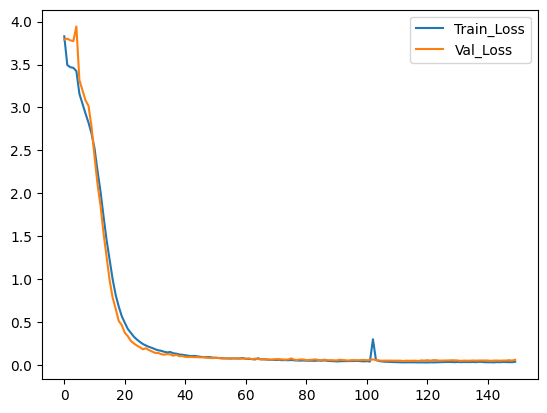

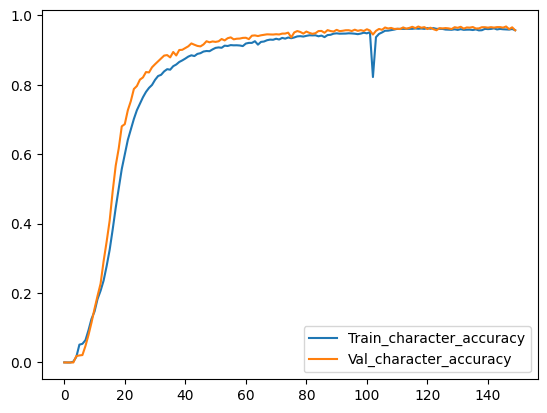

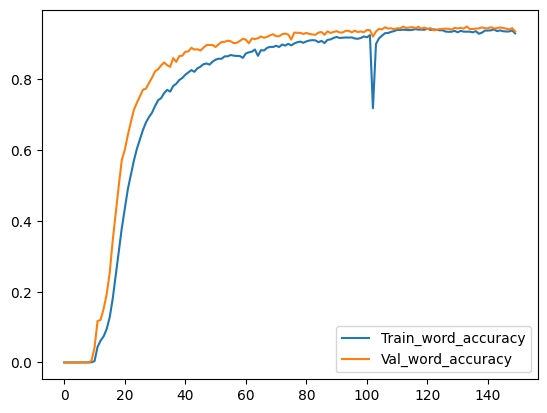

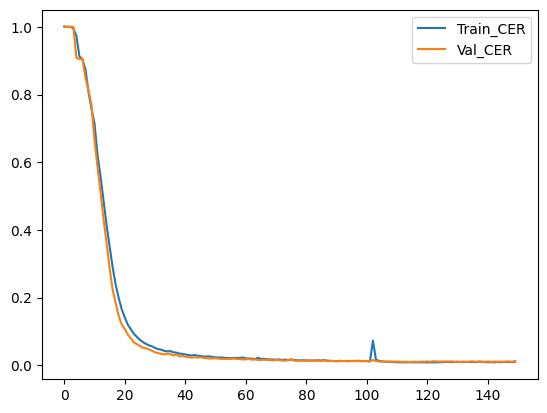

<Figure size 640x480 with 0 Axes>

In [41]:
importlib.reload(train)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = {"path": "Models/checkpoints/v0.01","log_path":"Logs", "metrics":["Train_Loss", "Val_Loss", "Train_CER"  ,"Val_CER" , "Train_character_accuracy", "Train_word_accuracy", "Val_character_accuracy", "Val_word_accuracy"]}
plots = {"path": "Plots"}
train_CRNN = train.Train(train_loader = train_data, val_loader = val_data, criterion=criterion, optimizer=optimizer, device = device, char_to_index=char_to_index, metrics=["character_accuracy", "word_accuracy", "CER"], num_epochs=150)
train_CRNN.fit(model=model,plots = plots, checkpoint= checkpoint)